In [2]:
import os
import numpy as np
import zipfile
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from PIL import Image

2023-04-09 23:04:49.725544: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-09 23:04:49.920575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-04-09 23:04:54.249915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-09 23:04:54.274207: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-09 23:04:54.274424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Data preprocessing

In [4]:
path = "dataset_primary/dataset_primary/data_05S01/"
no_attack_dir = os.listdir(path + "0/")
attack_dir = os.listdir(path + "1/")

In [5]:
# Load the images and labels into memory
images = np.zeros((len(no_attack_dir) + len(attack_dir), 112, 112, 3), dtype=np.float32)
labels = np.zeros(len(no_attack_dir) + len(attack_dir), dtype=np.int32)

# load the images and labels into memory
for i, filename in enumerate(no_attack_dir):
    img = Image.open(path + "0/" + filename).convert("RGB")
    img = img.resize((112, 112), Image.BILINEAR)
    img = np.asarray(img, dtype=np.float32)
    images[i] = img
for i, filename in enumerate(attack_dir):
    img = Image.open(path + "1/" + filename).convert("RGB")
    img = img.resize((112, 112), Image.BILINEAR)
    img = np.asarray(img, dtype=np.float32)
    images[i + len(no_attack_dir)] = img
    labels[i + len(no_attack_dir)] = 1

In [6]:
labels = tf.keras.utils.to_categorical(labels, 2)
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [7]:
# Shuffle the data and split into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)
del images, labels

# Models

In [8]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation="relu", input_shape=(112, 112, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 16)       0

2023-04-09 23:05:32.832357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-09 23:05:32.832648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-09 23:05:32.832785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
model.save_weights('pretraining/weights')

In [10]:
histories = []
batches = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]

In [11]:
for batch in batches:
    model.load_weights('pretraining/weights')
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    history = model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=batch,
        validation_data=(X_test, y_test),
    )
    
    histories.append(history)
    print(batch, "Done")

Epoch 1/10


2023-04-09 23:05:40.559653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-09 23:05:42.960959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-09 23:05:42.981041: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x1fe203b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-09 23:05:42.981082: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-04-09 23:05:42.990076: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-09 23:05:43.171992: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1797/1797 [==============================] - 16s 5ms/step - loss: 0.6257 - accuracy: 0.7874 - val_loss: 0.3870 - val_accuracy: 0.8143
Epoch 2/10
1797/1797 [==============================] - 8s 4ms/step - loss: 0.3774 - accuracy: 0.8224 - val_loss: 0.3695 - val_accuracy: 0.8277
Epoch 3/10
1797/1797 [==============================] - 7s 4ms/step - loss: 0.3603 - accuracy: 0.8271 - val_loss: 0.3479 - val_accuracy: 0.8268
Epoch 4/10
1797/1797 [==============================] - 7s 4ms/step - loss: 0.3494 - accuracy: 0.8306 - val_loss: 0.3435 - val_accuracy: 0.8326
Epoch 5/10
1797/1797 [==============================] - 7s 4ms/step - loss: 0.3370 - accuracy: 0.8363 - val_loss: 0.3484 - val_accuracy: 0.8317
Epoch 6/10
1797/1797 [==============================] - 8s 4ms/step - loss: 0.3259 - accuracy: 0.8390 - val_loss: 0.3171 - val_accuracy: 0.8388
Epoch 7/10
1797/1797 [==============================] - 7s 4ms/step - loss: 0.3196 - accuracy: 0.8390 - val_loss: 0.3336 - val_accuracy: 0.8312
Ep

150/150 [==============================] - 2s 12ms/step - loss: 0.3283 - accuracy: 0.8282 - val_loss: 0.3393 - val_accuracy: 0.8268
Epoch 6/10
150/150 [==============================] - 2s 12ms/step - loss: 0.3200 - accuracy: 0.8299 - val_loss: 0.3378 - val_accuracy: 0.8343
Epoch 7/10
150/150 [==============================] - 2s 12ms/step - loss: 0.3146 - accuracy: 0.8360 - val_loss: 0.3194 - val_accuracy: 0.8339
Epoch 8/10
150/150 [==============================] - 2s 12ms/step - loss: 0.3107 - accuracy: 0.8361 - val_loss: 0.3204 - val_accuracy: 0.8234
Epoch 9/10
150/150 [==============================] - 2s 12ms/step - loss: 0.3020 - accuracy: 0.8362 - val_loss: 0.3192 - val_accuracy: 0.8383
Epoch 10/10
150/150 [==============================] - 2s 12ms/step - loss: 0.3011 - accuracy: 0.8409 - val_loss: 0.3229 - val_accuracy: 0.8354
120 Done
Epoch 1/10
139/139 [==============================] - 4s 17ms/step - loss: 1.4914 - accuracy: 0.6757 - val_loss: 0.4246 - val_accuracy: 0.8061


# Results

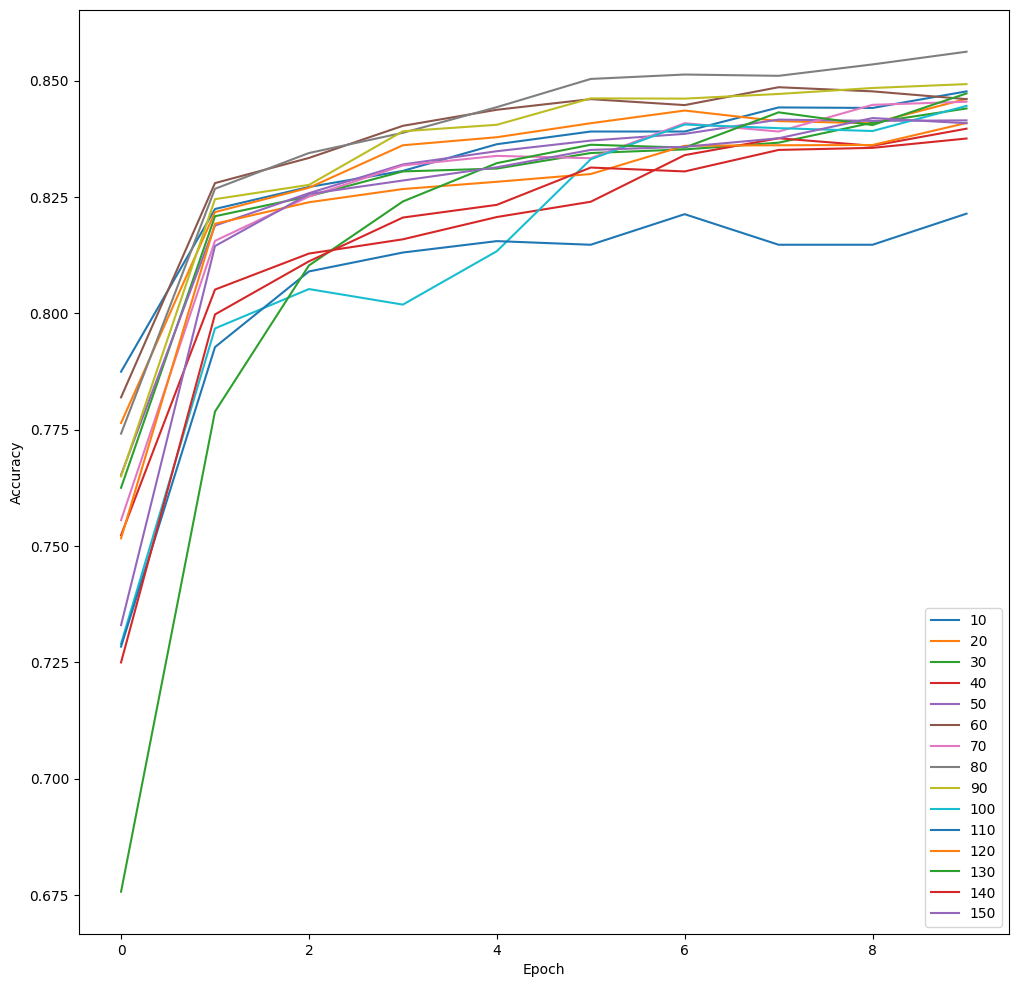

In [12]:
plt.figure(figsize=((12, 12)))

for batch, history in zip(batches, histories):    
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(acc))
    plt.plot(epochs, acc, label=batch)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

    

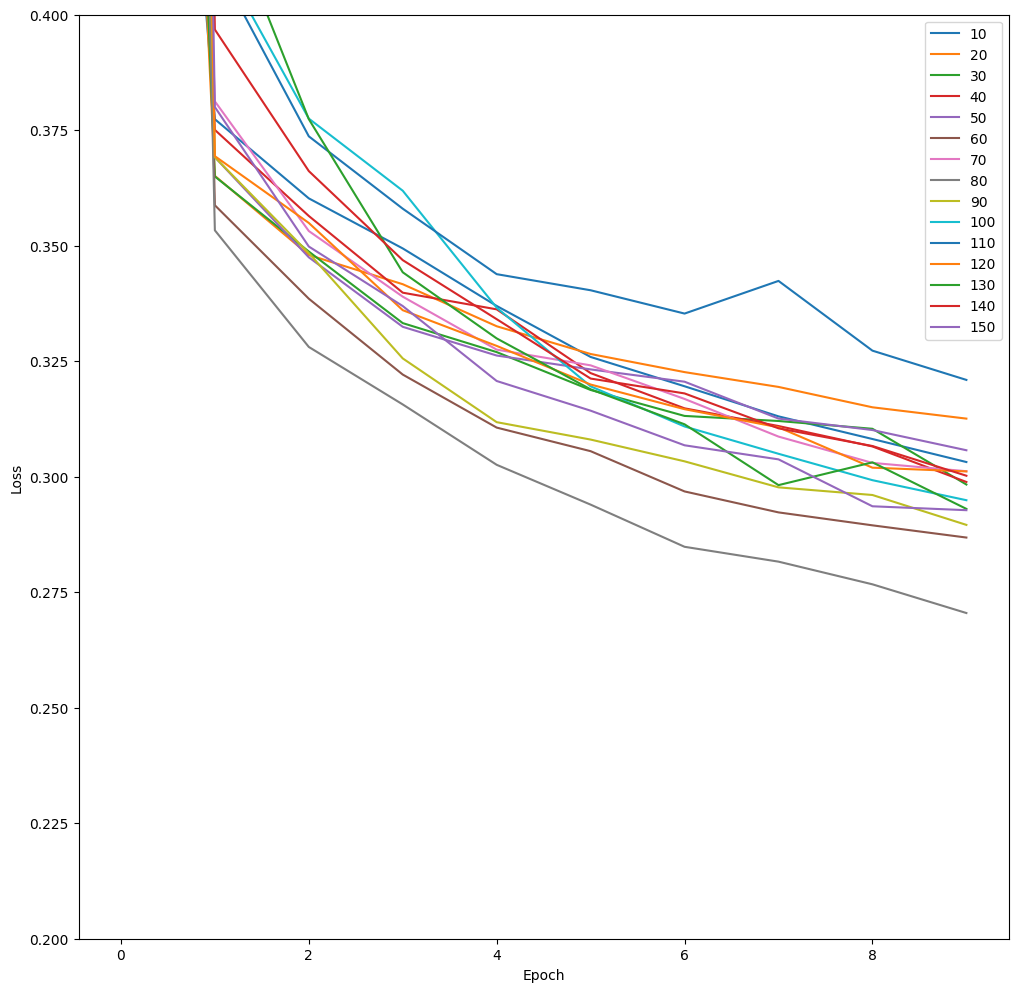

In [13]:
plt.figure(figsize=((12, 12)))

for batch, history in zip(batches, histories):    
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(acc))
    plt.plot(epochs, loss, label=batch)

plt.xlabel("Epoch")
plt.ylim((.2, .4))
plt.ylabel("Loss")
plt.legend()

    

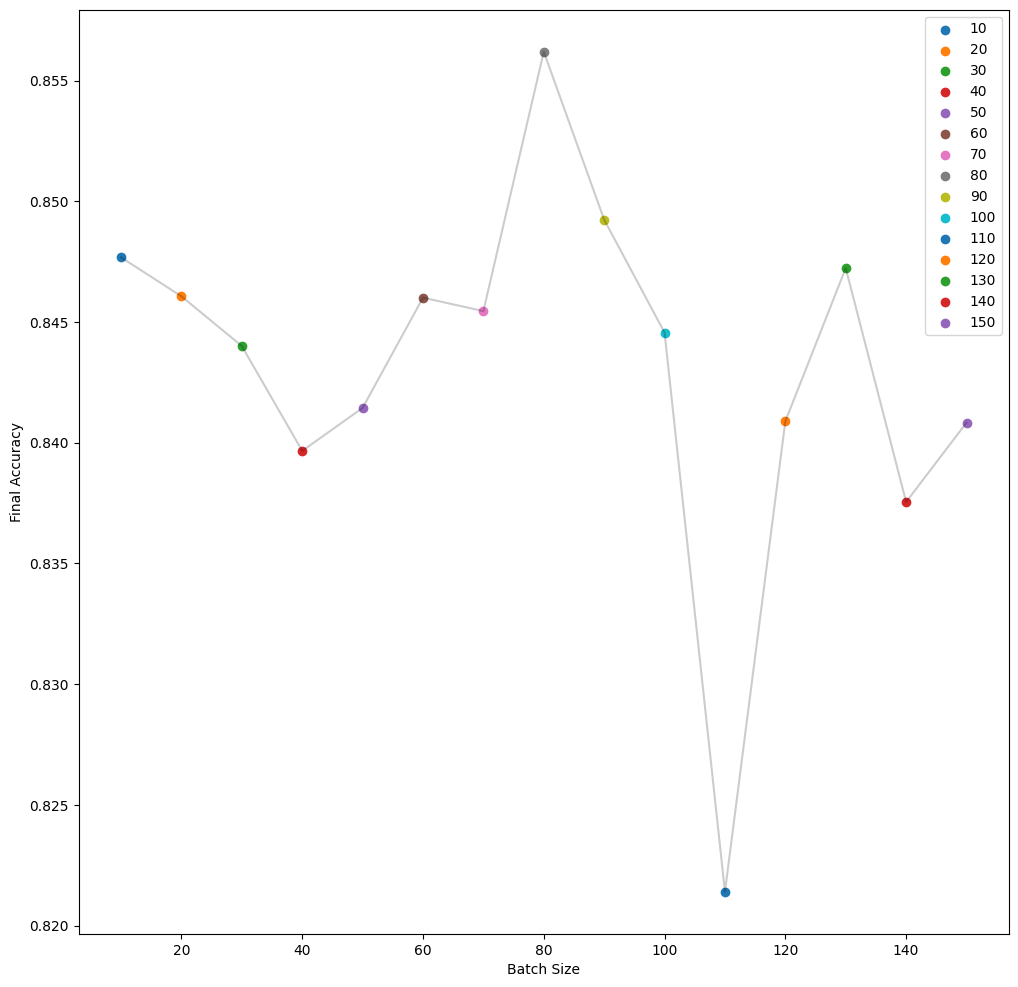

In [14]:
plt.figure(figsize=((12, 12)))

x = []
y = []

for batch, history in zip(batches, histories):    
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    plt.scatter(batch, acc[-1], label=batch)
    x.append(batch)
    y.append(acc[-1])

plt.plot(x, y, alpha=.2, color='black')
plt.ylabel("Final Accuracy")
plt.xlabel("Batch Size")
# plt.xlim((-0.01, 0.015))
plt.legend()


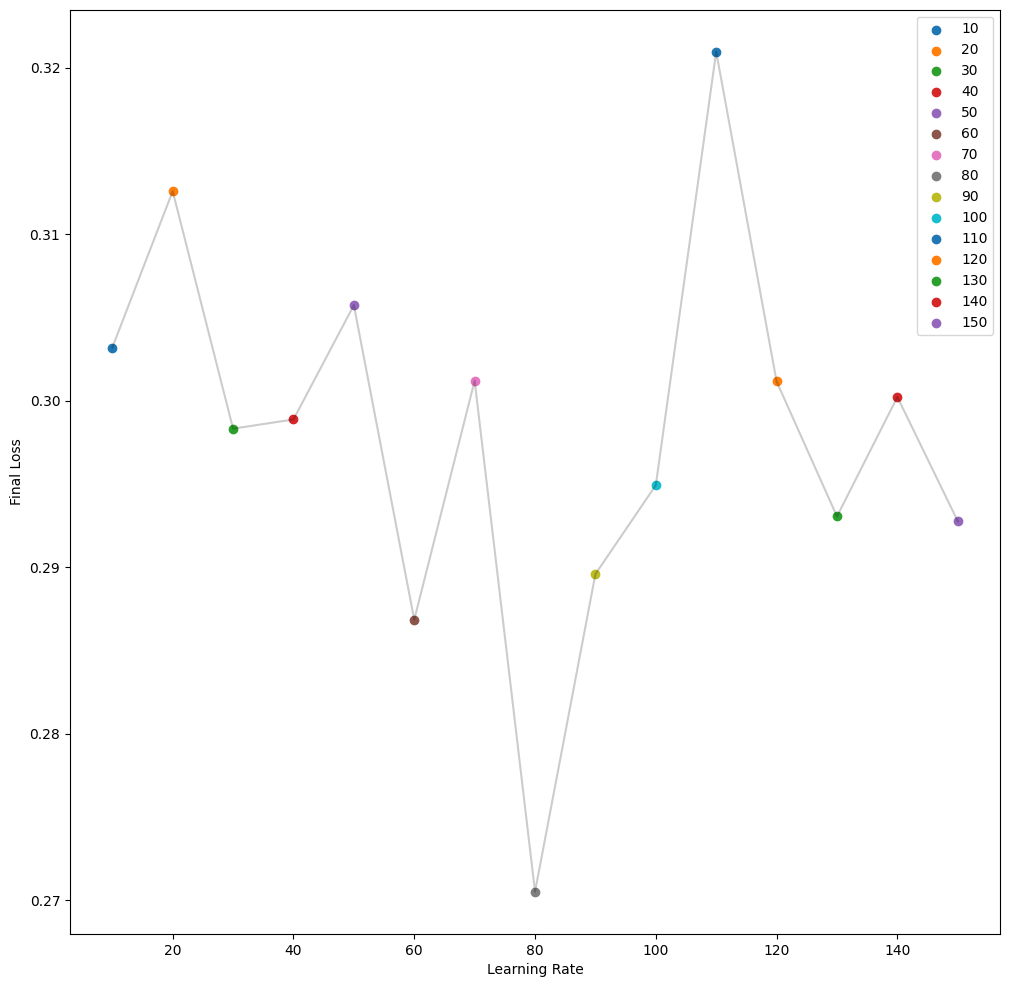

In [15]:
plt.figure(figsize=((12, 12)))

x = []
y = []

for batch, history in zip(batches, histories):    
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    plt.scatter(batch, loss[-1], label=batch)
    x.append(batch)
    y.append(loss[-1])

plt.plot(x, y, alpha=.2, color='black')
plt.ylabel("Final Loss")
plt.xlabel("Learning Rate")
# plt.xlim((-0.0001, 0.003))
plt.legend()
